<a href="https://colab.research.google.com/github/merongedrago/XAI_Mechanistic_Interpretability/blob/main/mechanistic_interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mechanistic Interpretability *by Meron Gedrago*

This notebook is based on a tutorial prepared by Dr. Brinnae Bent

In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np

### Data Generation

The following code generates random 8-bit binary sequences and labels each one with its parity (0 for even number of 1s, 1 for odd), producing training and validation tensors for a binary XOR-parity classification task.

In [90]:
import torch
import random

def generate_xor_parity_data(n_samples, seq_length):
    X = []
    y = []
    for _ in range(n_samples):
        binary_str = [random.choice([0, 1]) for _ in range(seq_length)]
        label = sum(binary_str) % 2  # Calculate parity (XOR sum)
        X.append(binary_str)
        y.append(label)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# Generate training and validation datasets
seq_length = 8
n_classes = seq_length + 1
X_train, y_train = generate_xor_parity_data(n_samples=2000, seq_length=seq_length)
X_val, y_val = generate_xor_parity_data(n_samples=500, seq_length=seq_length)

The above snippet of code was generated by Gemini on 6 am, November 14,2025

### Build a Tiny MLP (multilayer perceptron) Model

In [91]:
class CountingMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim,output_dim=1):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  # Output is a single scalar

    def forward(self, x):
        h = F.relu(self.fc1(x))
        out = self.fc2(h)
        return out, h  # for interpretability

# Instantiate model with output_dim=1 for binary classification
model = CountingMLP(input_dim=seq_length, hidden_dim=10, output_dim=1)
print(model)

# Convert targets to float (regression labels)
y_train_reg = y_train.float().unsqueeze(1)
y_val_reg = y_val.float().unsqueeze(1)

# Training loop with MSE loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

losses = []
for epoch in range(100):
    model.train()
    out, _ = model(X_train)
    loss = criterion(out, y_train_reg)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

print("Final training loss:", losses[-1])

# Evaluation: Mean Absolute Error + Rounded Accuracy
model.eval()
with torch.no_grad():
    preds, _ = model(X_val)
    mae = torch.abs(preds - y_val_reg).mean().item()
    rounded_preds = torch.round(preds).squeeze().long()
    accuracy = (rounded_preds == y_val).float().mean().item()

print(f"Validation MAE: {mae:.2f}")
print(f"Rounded Accuracy: {accuracy:.2f}")

CountingMLP(
  (fc1): Linear(in_features=8, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)
Final training loss: 0.24953709542751312
Validation MAE: 0.50
Rounded Accuracy: 0.53


### Print Activations of a sample input

In [92]:
with torch.no_grad():
    sample_input = torch.tensor([[1, 1, 1, 1, 1, 1, 1, 1]], dtype=torch.float32)
    logits, hidden = model(sample_input)

print(f"Sample Input: {sample_input}")
print(f"Hidden Layer Activations: {hidden}")
print(f"Output Logits: {logits}")
rounded = round(logits.item())
print(f"Rounded Prediction: {rounded}")

Sample Input: tensor([[1., 1., 1., 1., 1., 1., 1., 1.]])
Hidden Layer Activations: tensor([[0.0000, 0.0000, 0.0000, 0.1476, 1.0810, 0.0000, 0.0000, 0.0000, 0.2648,
         0.0029]])
Output Logits: tensor([[0.5385]])
Rounded Prediction: 1


### Plot hidden activations

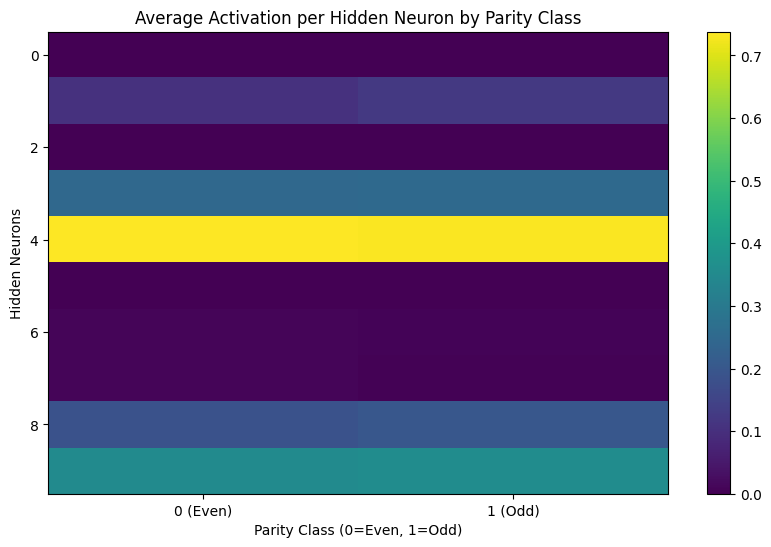

In [93]:
counts = list(range(n_classes))
avg_activations = torch.zeros((n_classes, 10))

for c in counts:
    class_inputs = X_val[y_val == c]
    if class_inputs.shape[0] > 0:
        _, h = model(class_inputs)
        avg_activations[c] = h.mean(dim=0)

plt.figure(figsize=(10, 6))
activations_np = avg_activations.T.detach().numpy()
plt.imshow(activations_np, aspect='auto', cmap='viridis')
plt.xlabel("Parity Class (0=Even, 1=Odd)")
plt.ylabel("Hidden Neurons")
plt.title("Average Activation per Hidden Neuron by Parity Class")
plt.xticks(ticks=[0, 1], labels=['0 (Even)', '1 (Odd)'])
plt.xlim(-0.5, 1.5)
plt.colorbar()
plt.show()

- The activation patterns look very similar across neurons for both even and odd parity classes, indicating no strong class-specific specialization overall.
- In this example, neuron 4 shows noticeably higher activation than the others, with neurons 3 and 8 also slightly more active compared to the rest.
- This suggests neuron 4 is reacting to some consistent feature of the input (e.g., number of 1s or a structured pattern), not directly to parity.

### Neuron Ablation (single neuron)

In [99]:
# Sample input to test
test_input = torch.tensor([[1, 1, 1, 1, 1, 1, 1, 1]], dtype=torch.float32)  # Example: 4 ones
true_count = int(test_input.sum().item())

# Baseline prediction
model.eval()
with torch.no_grad():
    baseline_output, _ = model(test_input)
    baseline_pred = baseline_output.item()

# Zero out one neuron in the hidden layer (e.g., neuron 4)
neuron_to_zero = 4

# Manually run forward pass with neuron ablated
with torch.no_grad():
    h = F.relu(model.fc1(test_input))
    h[:, neuron_to_zero] = 0  # zeroing neuron
    modified_output = model.fc2(h)
    modified_pred = modified_output.item()


print(f"True count: {true_count}")
print(f"Prediction (normal): {baseline_pred:.2f}")
print(f"Prediction (with neuron {neuron_to_zero} zeroed): {modified_pred:.2f}")

delta = modified_pred - baseline_pred
if delta > 0:
    print(f"➕ Prediction increased by {delta:.2f}")
elif delta < 0:
    print(f"➖ Prediction decreased by {abs(delta):.2f}")
else:
    print("⚖️ No change in prediction")


True count: 8
Prediction (normal): 0.54
Prediction (with neuron 4 zeroed): 0.10
➖ Prediction decreased by 0.44


True parity: 0
Baseline prediction (logit): 0.54
Baseline Class Prediction: 1

--- Ablation Results per Hidden Neuron ---


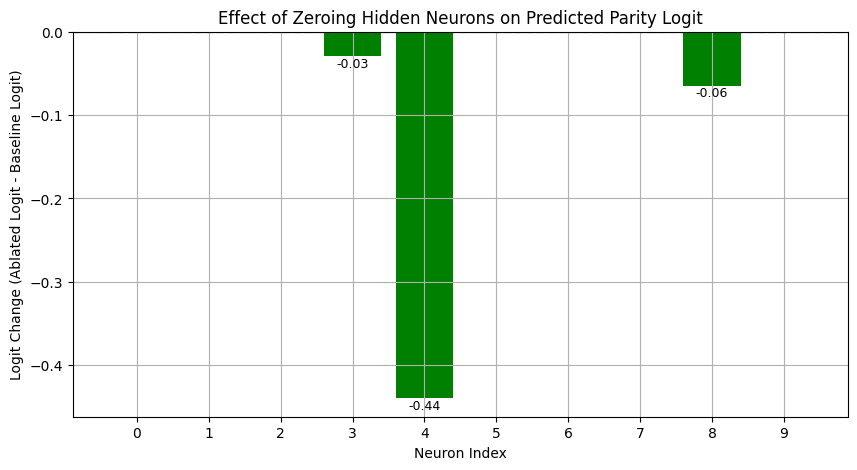

In [100]:
# Sample input to test
true_parity = int(test_input.sum().item()) % 2

# Baseline prediction
model.eval()
with torch.no_grad():
    baseline_output, _ = model(test_input)
    baseline_pred = baseline_output.item() # This is the logit
    baseline_class_pred = torch.round(torch.sigmoid(baseline_output)).item() # Convert to binary class prediction

print(f"True parity: {true_parity}")
print(f"Baseline prediction (logit): {baseline_pred:.2f}")
print(f"Baseline Class Prediction: {int(baseline_class_pred)}\n")

# Get the number of hidden neurons
hidden_dim = model.fc1.out_features

signed_deltas = []

print("--- Ablation Results per Hidden Neuron ---")
for neuron_to_zero in range(hidden_dim):
    # Manually run forward pass with current neuron ablated
    with torch.no_grad():
        h = F.relu(model.fc1(test_input))
        h_ablated = h.clone() # Create a copy to modify
        h_ablated[:, neuron_to_zero] = 0  # zeroing current neuron
        modified_output = model.fc2(h_ablated)
        modified_pred = modified_output.item() # This is the ablated logit
        modified_class_pred = torch.round(torch.sigmoid(modified_output)).item() # Convert to binary class prediction

    signed_deltas.append(modified_pred - baseline_pred)


# Plotting signed prediction change per neuron (for logits)
plt.figure(figsize=(10, 5))
colors = ['green' if d < 0 else 'red' if d > 0 else 'gray' for d in signed_deltas]

neuron_indices = list(range(hidden_dim))
plt.bar(neuron_indices, signed_deltas, color=colors)
plt.axhline(0, color='black', linestyle='--')
plt.xticks(neuron_indices)
plt.xlabel("Neuron Index")
plt.ylabel("Logit Change (Ablated Logit - Baseline Logit)")
plt.title("Effect of Zeroing Hidden Neurons on Predicted Parity Logit")
plt.grid(True)

# Annotation
for i, d in enumerate(signed_deltas):
    if abs(d) > 1e-3:
        plt.text(i, d + (0.001 if d > 0 else -0.001), f"{d:+.2f}",
                 ha='center', va='bottom' if d > 0 else 'top', fontsize=9)

plt.show()

Neuron 4 consistently shows the strongest activation, indicating it is detecting a meaningful intermediate feature of the input rather than parity itself. It likely acts as a feature-extractor that the final layer uses to compute the XOR outcome.

## Reflections

- I was surprised that changing the test input caused big shifts in which neurons activated, and I didn’t always understand why.

- It was interesting but confusing that even when a neuron activated strongly, its exact role was still unclear.

*the above text was edited using GPT5 at 8:30 am, November 14, 2025*